In [1]:
import os
import zipfile
import random
from sklearn.model_selection import train_test_split
import pandas as pd

import shutil
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
base_dir = "dogs_vs_cats"
train_zip = "/content/train.zip"
test_zip = "/content/test1.zip"

In [3]:
# Create necessary directories
if not os.path.exists(base_dir):
    os.makedirs(base_dir)
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test1")
train_data_dir = os.path.join(base_dir, "training_data")
val_data_dir = os.path.join(base_dir, "validation_data")

In [4]:
# Extract train data
if not os.path.exists(train_dir):
    with zipfile.ZipFile(train_zip, 'r') as zip_ref:
        zip_ref.extractall(base_dir)

In [5]:
# Extract  test data
if not os.path.exists(test_dir):
    with zipfile.ZipFile(test_zip, 'r') as zip_ref:
        zip_ref.extractall(base_dir)

In [6]:
# Prepare directories for training and validation data
if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)
if not os.path.exists(val_data_dir):
    os.makedirs(val_data_dir)

In [7]:
# Split Data into Training and Validation Sets
all_images = os.listdir(train_dir)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)

In [8]:
def organize_data(image_list, source_dir, target_dir):
    for img in image_list:
        category = "dog" if "dog" in img else "cat"
        target_path = os.path.join(target_dir, category)
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        shutil.copy(os.path.join(source_dir, img), os.path.join(target_path, img))

In [9]:
organize_data(train_images, train_dir, train_data_dir)
organize_data(val_images, train_dir, val_data_dir)

In [10]:
# Display sample images
def show_samples(base_folder, category, sample_count=3):
    path = os.path.join(base_folder, category)
    images = os.listdir(path)[:sample_count]
    plt.figure(figsize=(10, 5))
    for i, img_name in enumerate(images):
        img = plt.imread(os.path.join(path, img_name))
        plt.subplot(1, sample_count, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
    plt.show()

In [11]:
# Print folder statistics
def folder_stats(base_folder):
    for category in ['dog', 'cat']:
        path = os.path.join(base_folder, category)
        print(f"{category.capitalize()} images in {base_folder}: {len(os.listdir(path))}")

Training Data:
Dog images in dogs_vs_cats/training_data: 9999
Cat images in dogs_vs_cats/training_data: 10001


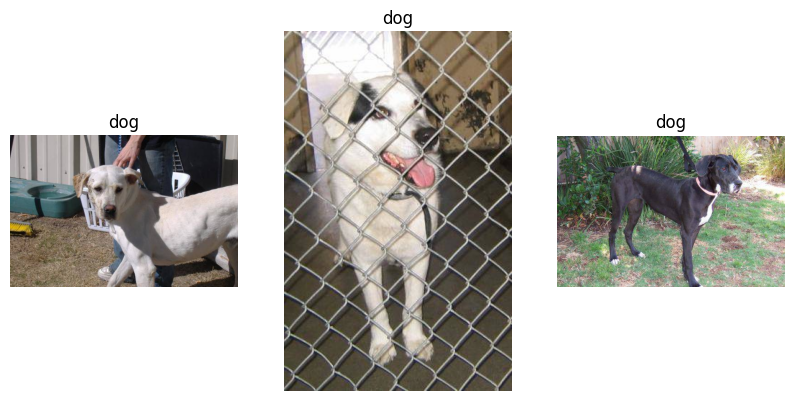

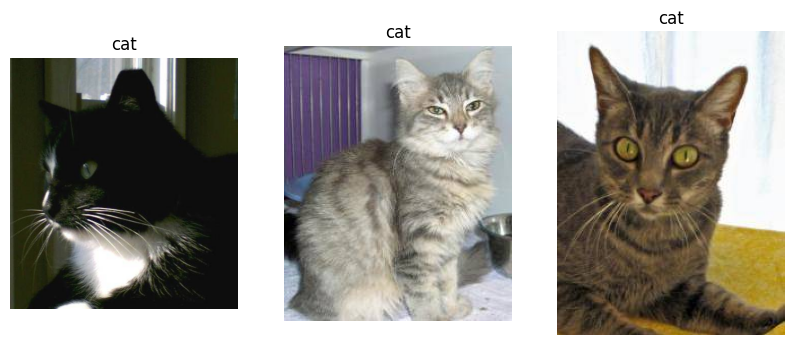

In [12]:
# Show statistics and sample images
print("Training Data:")
folder_stats(train_data_dir)
show_samples(train_data_dir, 'dog')
show_samples(train_data_dir, 'cat')

Validation Data:
Dog images in dogs_vs_cats/validation_data: 2501
Cat images in dogs_vs_cats/validation_data: 2499


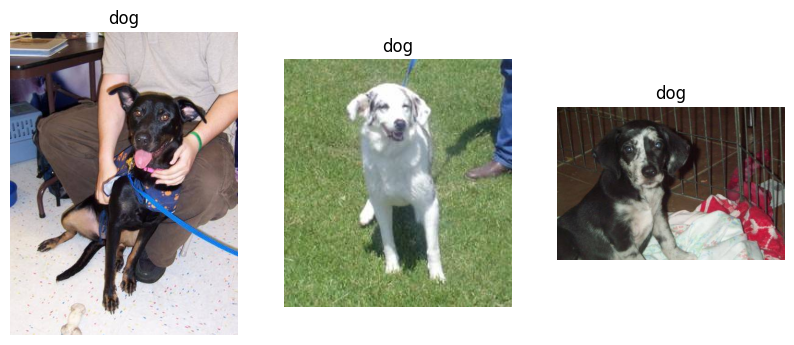

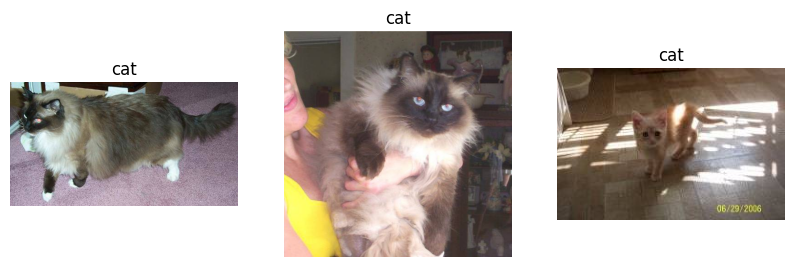

In [13]:
print("Validation Data:")
folder_stats(val_data_dir)
show_samples(val_data_dir, 'dog')
show_samples(val_data_dir, 'cat')

In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [17]:
val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [18]:
pretrained_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
# Freeze pre-trained layers
for layer in pretrained_model.layers:
    layer.trainable = False

In [20]:
# Add  layers
x = layers.Flatten()(pretrained_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(1, activation='sigmoid')(x)

In [21]:
model = Model(pretrained_model.input, x)

In [22]:
# Compile  model
model.compile(
    optimizer=RMSprop(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
# add calback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("cats_dogs_model.keras", save_best_only=True)

In [24]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 175s 254ms/step - accuracy: 0.8653 - loss: 0.9428 - val_accuracy: 0.9534 - val_loss: 0.1248
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 236ms/step - accuracy: 0.9249 - loss: 0.2040 - val_accuracy: 0.9660 - val_loss: 0.0920
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 243ms/step - accuracy: 0.9275 - loss: 0.1848 - val_accuracy: 0.9674 - val_loss: 0.0871
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 233ms/step - accuracy: 0.9289 - loss: 0.1840 - val_accuracy: 0.9680 - val_loss: 0.0888
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 206s 239ms/step - accuracy: 0.9363 - loss: 0.1752 - val_accuracy: 0.9664 - val_loss: 0.0921
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 236ms/step - accuracy: 0.9367 - loss: 0.1642 - val_accuracy: 0.9654 - val_loss: 0.1112
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 236ms/step - accuracy: 0.9403 - loss: 0.1613 - val_accuracy: 0.9690 - val_loss: 0.0920
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 236ms/step - accuracy: 0.9377 - loss: 0.16

In [25]:
def plot_training_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

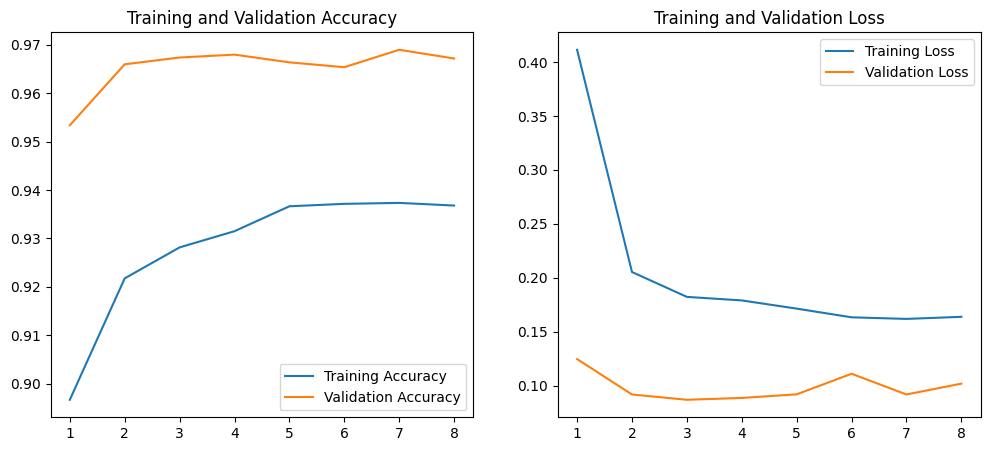

In [26]:
plot_training_results(history)

In [27]:
# Get all image file paths in the test directory
image_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.jpg')]

# Create a DataFrame with the file paths
df = pd.DataFrame({'filename': image_paths})


# Create an ImageDataGenerator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load images using flow_from_dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    x_col='filename',  # Image file paths
    target_size=(150, 150),  # Resize images
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 12500 validated image filenames.


In [28]:
# Print the number of images found
print(f"Found {len(test_generator.filenames)} images in the test directory.")

Found 12500 images in the test directory.


In [29]:
predictions = model.predict(test_generator)
predicted_classes = [1 if pred > 0.5 else 0 for pred in predictions]

391/391 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step


In [30]:
filenames = test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Prediction": predicted_classes})
results.to_csv("submission.csv", index=False)